In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
!cp -r gdrive/My\ Drive/tools/ .
!cp -r gdrive/My\ Drive/models/ .
!cp -r gdrive/My\ Drive/x96_extrapolation/ .
!ls -l

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive
total 20
drwx------ 3 root root 4096 May  1 18:21 gdrive
drwx------ 3 root root 4096 May  1 18:22 models
drwxr-xr-x 1 root root 4096 Apr 29 16:32 sample_data
drwx------ 3 root root 4096 May  1 18:22 tools
drwx------ 2 root root 4096 May  1 18:23 x96_extrapolation


In [2]:
import numpy as np
import torch
import torch.nn as nn

import models.autoencoder as AE
import tools._my_tools as mt
import tools._torch_tools as tt

import tools.AR_data as ar

device = device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device is", device)

data_f = "x96_extrapolation/"
X_train, y_train, X_val, y_val = mt.loadData(data_f,train=True, val=True,typeF='float16')

Device is cuda:0
Loading x96_extrapolation/X_train.npy
Loading x96_extrapolation/y_train.npy
Loading x96_extrapolation/X_val.npy
Loading x96_extrapolation/y_val.npy


In [0]:
ae = AE.Model("models/data/autoencoder.pth",device=device).to(device).eval()

In [0]:
class Model(nn.Module):
    def __init__(self, batch_size):
        super(Model, self).__init__()
        
        self.batch_size = batch_size
        self.lstm = nn.LSTM(576,1152,num_layers=3,dropout=0.05)
        self.linear = nn.Linear(1152,576)
    
    def predict(self, x):   
        out, hid = self.lstm(x)
        res = self.linear(out[-1:].view(1,-1)).view(1,1,-1)
        
        for i in range(x.shape[0] - 1):
            out, hid = self.lstm(res[-1:], hid)
            res = torch.cat((res,self.linear(out[-1:].view(1,-1)).view(1,1,-1)),0)
        
        return res
    
    def forward(self, x):
        x = x.view(3,self.batch_size,-1)
        
        out, hid = self.lstm(x)
        res = self.linear(out[-1:].view(self.batch_size,-1))
        
        return res.view(1,self.batch_size,-1)

class Training(tt.Training):
    def __init__(self,*args,**kwargs):
        super(Training,self).__init__(*args,**kwargs)
        self.ae = AE.Model("models/data/autoencoder.pth",device=device).to(device).eval()
        
    def getBatch(self, offset, batch_size, val=False):
        if val is True:
            X = self.X_val
            y = self.y_val
        else:
            X = self.X
            y = self.y

        input = torch.autograd.Variable(
            torch.tensor( X[ offset:offset + batch_size ], dtype=torch.float )
        ).to(self.device)
        input = self.ae.encode(input.view(input.shape[1]*batch_size,1,input.shape[2],input.shape[3]))
#         print(input.shape)

        target = torch.autograd.Variable(
            torch.tensor( y[ offset:offset + batch_size ], dtype=torch.float )
        ).to(self.device)
        target = self.ae.encode(target.view(target.shape[1]*batch_size,1,target.shape[2],target.shape[3]))
#         print(target.shape)

        return input.view(3,batch_size,-1), target.view(3,batch_size,-1)[0:1]

class Model2(nn.Module):
    def __init__(self, batch_size):
        super(Model, self).__init__()
        
        self.ae = AE.Model("models/data/autoencoder.pth",device=device).to(device).eval()
        self.batch_size = batch_size
        self.lstm = nn.LSTM(576,1152,num_layers=3,dropout=0.05)
        self.linear = nn.Linear(1152,576)
    
    def predict(self, x):
        out, hid = self.lstm(x)
        res = self.linear(out[-1:].view(1,-1)).view(1,1,-1)
        
        for i in range(x.shape[0] - 1):
            out, hid = self.lstm(res[-1:], hid)
            res = torch.cat((res,self.linear(out[-1:].view(1,-1)).view(1,1,-1)),0)
        
        return res
    
    def forward(self, x):
        x = x.view(x.shape[0]*x.shape[1],1,x.shape[2],x.shape[3])
        x = self.ae.encode()
        
        out, hid = self.lstm(x)
        res = self.linear(out[-1:].view(self.batch_size,-1))
        
        return res.view(1,self.batch_size,-1)

In [0]:
test = Model().to(device)
a = torch.tensor(X_val[0:1,:,:,:],dtype=torch.float).to(device)
tar = torch.tensor(y_val[0:1,:,:,:],dtype=torch.float).to(device)
b = ae.encode(a.view(3,1,96,96))
print(b.shape)
b = b.view(3,1,-1)
print(b.shape)
out = test(b)
print(out.shape)

torch.Size([3, 16, 6, 6])
torch.Size([3, 1, 576])
torch.Size([1, 1, 576])


In [0]:
model = Model(16)
training = Training(model, device, X_train, y_train, X_val, y_val, loss_function=nn.MSELoss())
# a = training.getBatch(0,1)
# print(a[0].shape)
# print(a[1].shape)

In [39]:
try:
    training.fit(16,2,val=True)
except KeyboardInterrupt:
    print("\n------------\nFinished training.")

====== HYPERPARAMETERS ======
batch_size : 16
epochs : 2
loss function : MSELoss()
optimizer : Adamax (
Parameter Group 0
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.002
    weight_decay: 0
)
device : cuda:0
===> Epoch[1](4225/4225): Loss: 0.0581	ETA 0:00:00	Epoch Loss: 0.0359
Epoch[1] finished in 0:03:30 with loss 0.03586595339998162
Validating on 16896 samples.
===> Validating (1056/1056):	ETA 0:00:00	Validation Loss: 0.0354
Validation loss = 0.0354

----------------------------

===> Epoch[2](4225/4225): Loss: 0.0576	ETA 0:00:00	Epoch Loss: 0.0347
Epoch[2] finished in 0:03:29 with loss 0.034739647908191354
Validating on 16896 samples.
===> Validating (1056/1056):	ETA 0:00:00	Validation Loss: 0.0351
Validation loss = 0.0351

----------------------------

Finished training of 2 epochs in 0:07:26.


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))


(96, 288)
(96, 192)


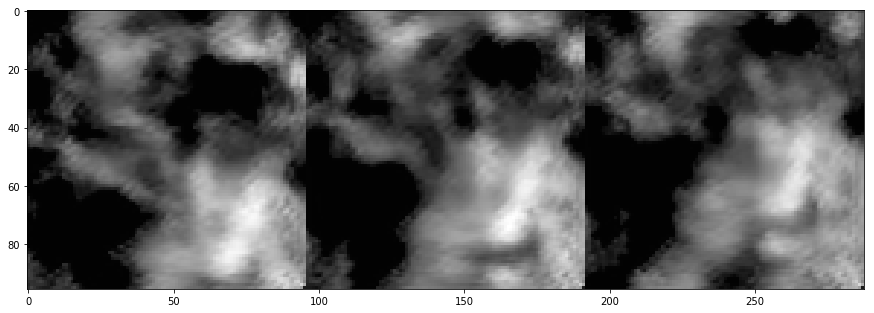

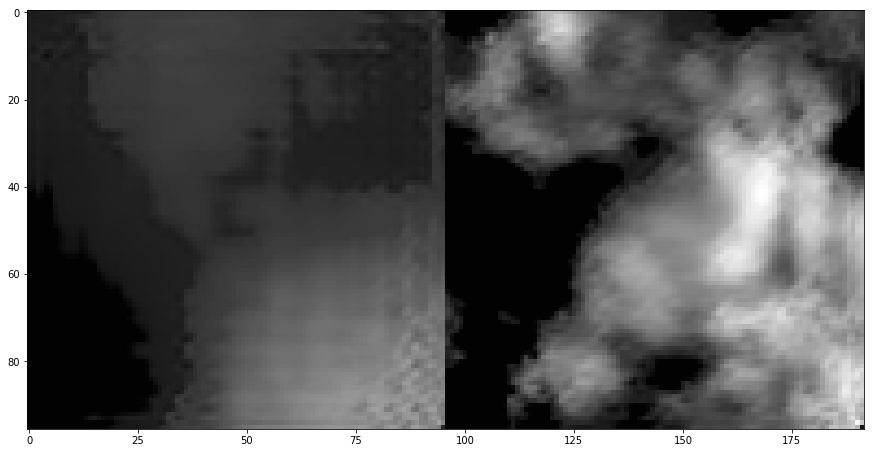

In [40]:
a,b = training.getBatch(5,1,val=True)
out = model.predict(a)
# print(out[0,0])
out = out.view(-1,16,6,6)
res = training.ae.decode(out).cpu().detach().numpy()
tar = b.view(-1,16,6,6)
tar = training.ae.decode(tar).cpu().detach().numpy()
# print(res.shape)
i = 0
tmp = training.ae.decode(a.view(-1,16,6,6)).cpu().detach().numpy()
# print(tmp.shape)
mt.showImgGC("",tmp[0,0,:,:].astype('float32'),tmp[1,0,:,:].astype('float32'),tmp[2,0,:,:].astype('float32'),size=(15,15))
mt.showImgGC("",res[i,0,:,:].astype('float32'),tar[0,0,:,:].astype('float32'),size=(15,15))

(96, 192)
(96, 192)
(96, 192)
(96, 192)
(96, 192)
(96, 192)
(96, 192)
(96, 192)
(96, 192)
(96, 192)
(96, 192)
(96, 192)
(96, 192)
(96, 192)
(96, 192)
(96, 192)
(96, 192)
(96, 192)
(96, 192)
(96, 192)


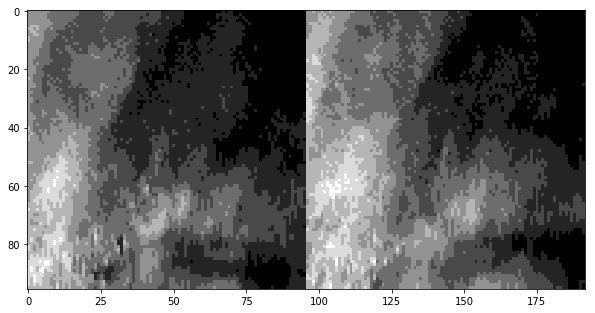

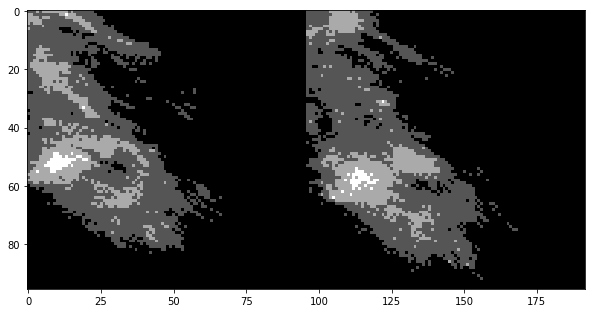

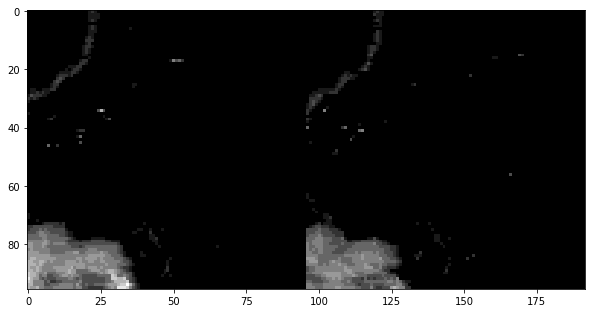

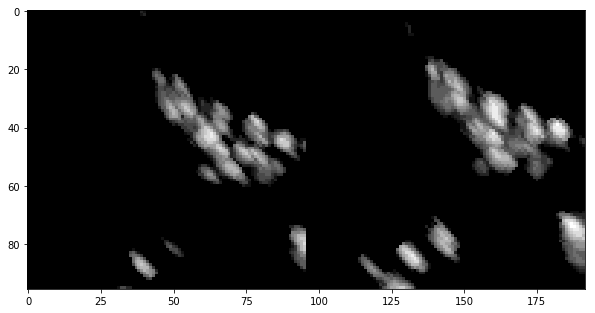

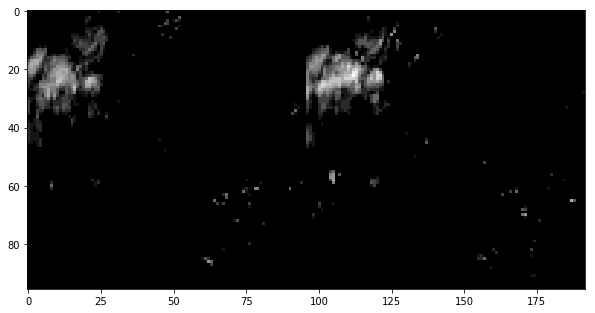

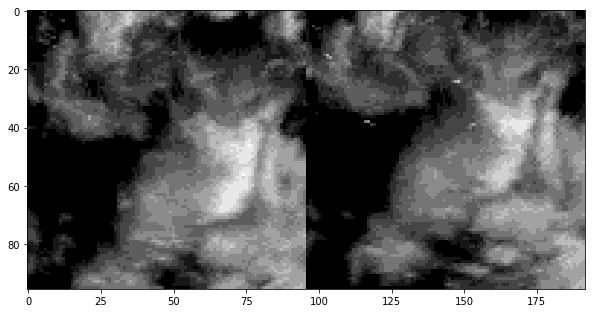

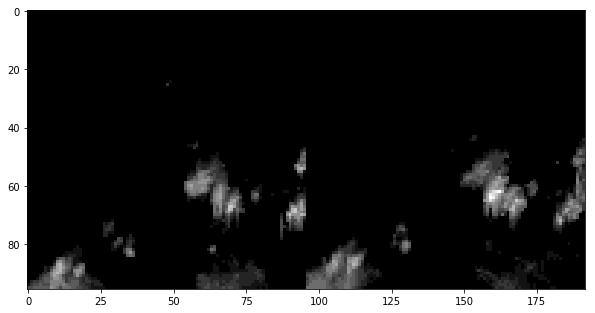

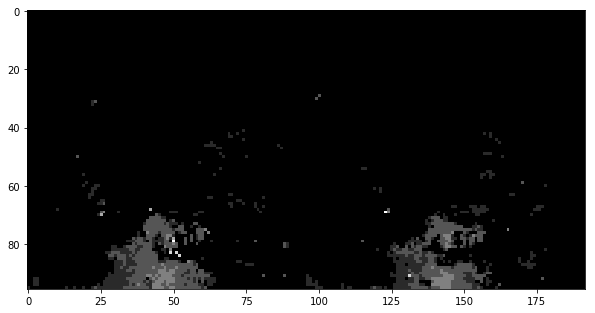

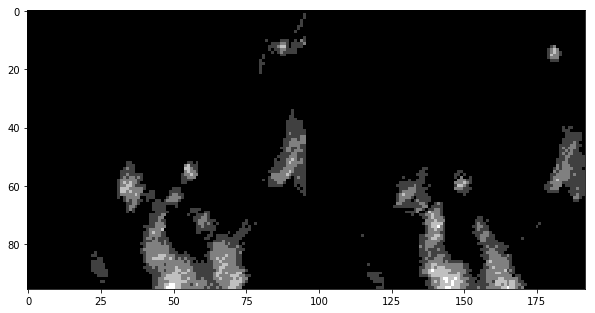

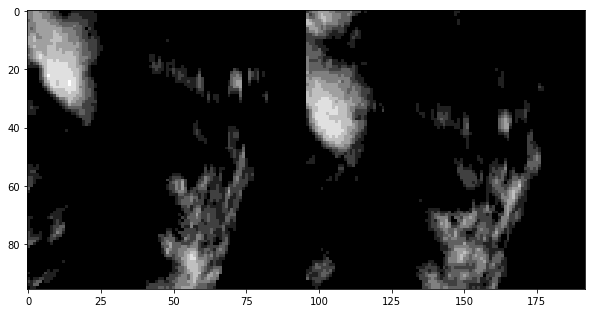

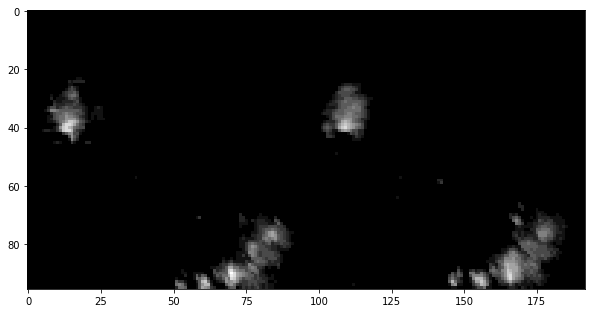

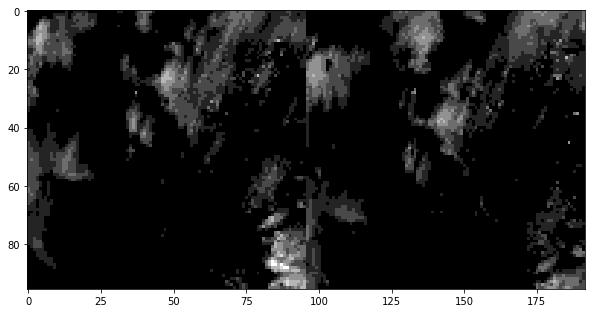

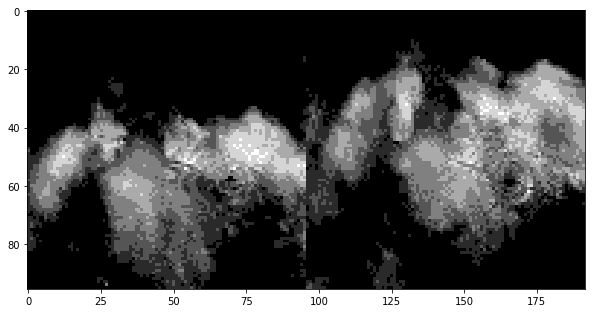

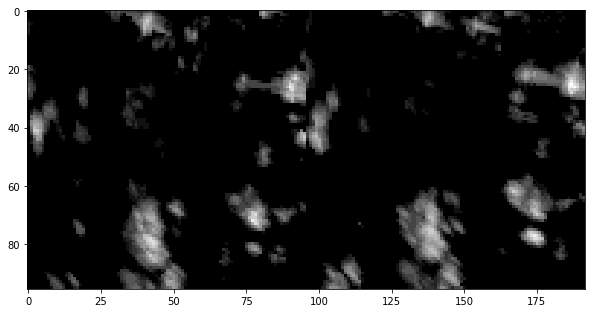

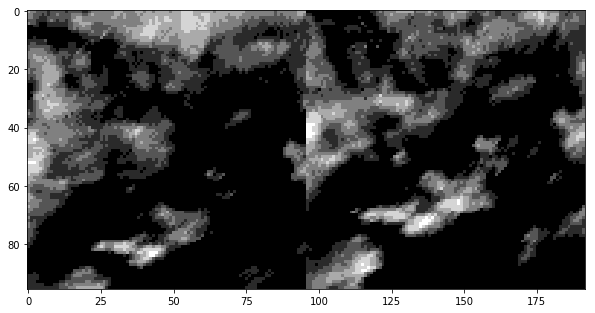

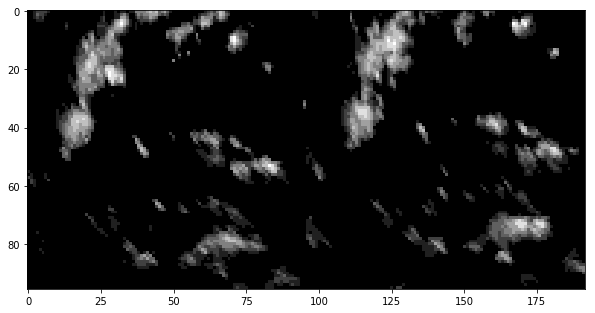

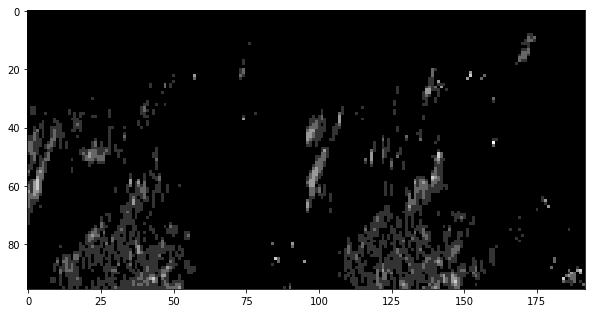

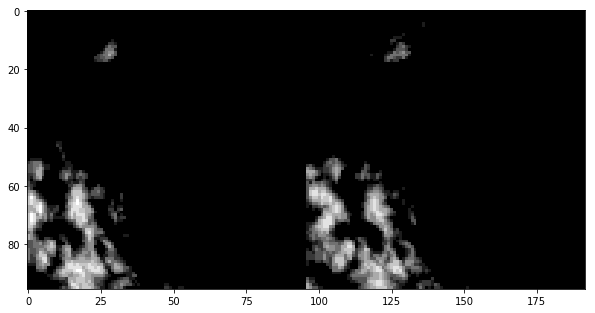

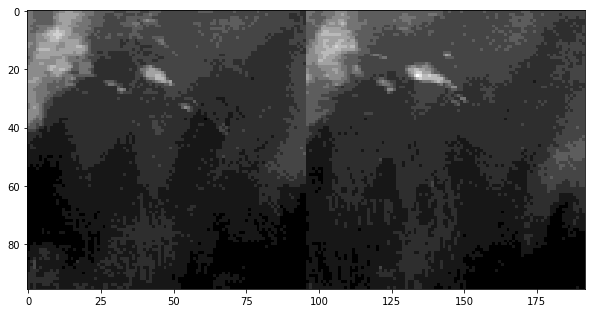

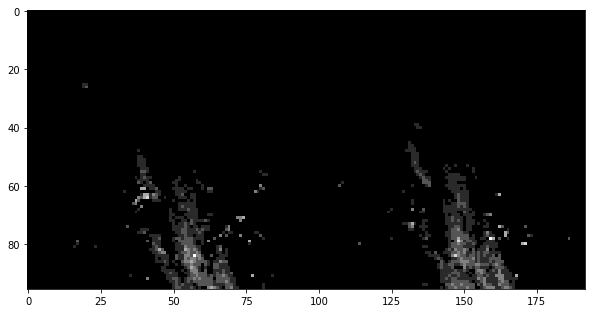

In [4]:
for i in range(20):
    mt.showImgGC("",X_val[i,2,:,:].astype('float32'),y_val[i,0,:,:].astype('float32'),size=(10,10))

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))


(96, 192)


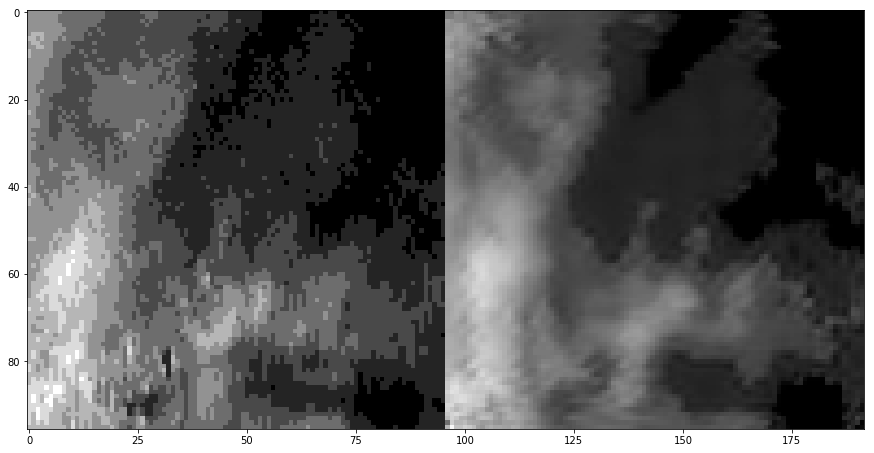

In [0]:
a = X_train[0:1,2:,:,:]
b = ae.encode(torch.tensor(a,dtype=torch.float).to(device)).view(-1).view(-1,16,6,6)
c = ae.decode(b).cpu().detach().numpy()
mt.showImgGC("",a.squeeze().astype('float32'),c.squeeze().astype('float32'),size=(15,15))